# 케라스 보스턴 주택 가격 모델

### modules import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import shap
plt.style.use(["seaborn-white"])

from tensorflow.keras.datasets.boston_housing import load_data
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.legacy import Adam

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

/Users/yanghaejun/miniforge3/envs/yang_tensor/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/yanghaejun/miniforge3/envs/yang_tensor/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for deta

### 데이터 로드
- 데이터의 수가 상당히 적기 때문에 테스트 데이터의 비율을 20%로 지정

- 13개의 특성을 가짐

- 각각의 특성이 모두 다른 스케일, 즉 단위가 모두 다름
  - 범죄율: 0~1 사이의 값
  - 방의 개수 3~9 사이의 값

- 정답 레이블은 주택 가격의 중간가격($1000 단위)

In [2]:
tf.random.set_seed(111)

(x_train_full, y_train_full), (x_test, y_test) = load_data()

In [3]:
help(load_data)

Help on function load_data in module keras.datasets.boston_housing:

load_data(path='boston_housing.npz', test_split=0.2, seed=113)
    Loads the Boston Housing dataset.
    
    This is a dataset taken from the StatLib library which is maintained at
    Carnegie Mellon University.
    
    **WARNING:** This dataset has an ethical problem: the authors of this
    dataset included a variable, "B", that may appear to assume that racial
    self-segregation influences house prices. As such, we strongly discourage
    the use of this dataset, unless in the context of illustrating ethical
    issues in data science and machine learning.
    
    Samples contain 13 attributes of houses at different locations around the
    Boston suburbs in the late 1970s. Targets are the median values of
    the houses at a location (in k$).
    
    The attributes themselves are defined in the
    [StatLib website](http://lib.stat.cmu.edu/datasets/boston).
    
    Args:
      path: path where to cache the

### 데이터 확인

In [4]:
print("학습 데이터: {}\t레이블: {}".format(x_train_full.shape, y_train_full.shape))
print("테스트 데이터: {}\t레이블: {}".format(x_test.shape, y_test.shape))

학습 데이터: (404, 13)	레이블: (404,)
테스트 데이터: (102, 13)	레이블: (102,)


In [5]:
print(x_train_full[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


In [6]:
print(y_train_full[0])

15.2


### 데이터 전처리
- Standardization

- 특성의 단위가 모두 다르기 때문에 **동일한 범위로 조정**

In [7]:
# 데이터 정규화
scaler = StandardScaler()
x_train_scale, x_test_scale = scaler.fit_transform(x_train_full), scaler.fit_transform(x_test)

# 학습/검증 데이터 분류
x_train, x_val, y_train, y_val = train_test_split(x_train_scale, y_train_full, test_size=0.3, random_state=111)

In [8]:
print("학습 데이터: {}\t레이블: {}".format(x_train_full.shape, y_train_full.shape))
print("학습 데이터: {}\t레이블: {}".format(x_train.shape, y_train.shape))
print("검증 데이터: {}\t레이블: {}".format(x_val.shape, y_val.shape))
print("테스트 데이터: {}\t레이블: {}".format(x_test.shape, y_test.shape))

학습 데이터: (404, 13)	레이블: (404,)
학습 데이터: (282, 13)	레이블: (282,)
검증 데이터: (122, 13)	레이블: (122,)
테스트 데이터: (102, 13)	레이블: (102,)


### 모델 구성
- 학습 데이터가 매우 적은 경우에 모델의 깊이를 깊게 할수록  
  과대적합(Overfitting)이 일어날 확률이 높음

In [9]:
model = Sequential([Input(shape=(13, ), name="input"),
                    Dense(100, activation="relu", name="dense1"),
                    Dense(64, activation="relu", name="dense2"),
                    Dense(32, activation="relu", name="dense3"),
                    Dense(1, name="output")])

model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 100)               1400      
                                                                 
 dense2 (Dense)              (None, 64)                6464      
                                                                 
 dense3 (Dense)              (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 9,977
Trainable params: 9,977
Non-trainable params: 0
_________________________________________________________________


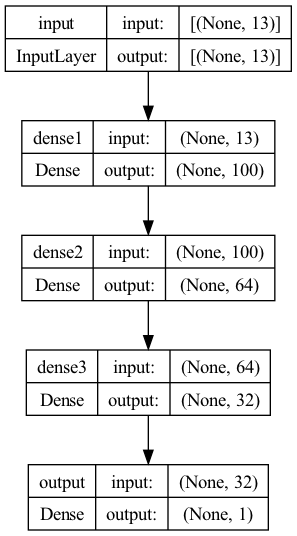

In [10]:
plot_model(model, show_shapes=True)

### 모델 컴파일(compile)

- 회귀 문제에서는 주로 평균제곱오차(MSE, Mean Squared Error)를 손실함수로,  
  평균절대오차(MAE, Mean Absolute Error)를 평가지표로 많이 사용!

In [11]:
model.compile(optimizer="adam",
              loss="mean_squared_error",
              metrics=["mae"])

### 모델 학습

In [12]:
model_hist = model.fit(x_train, y_train,
                       epochs=300,
                       validation_data=(x_val, y_val), 
                       verbose=2)

y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

print("Train R2: {}\tValidation R2: {}".format(r2_score(y_train, y_train_pred), r2_score(y_val, y_val_pred)))

Epoch 1/300


2023-07-27 19:03:52.564701: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


9/9 - 1s - loss: 544.7838 - mae: 21.5221 - val_loss: 545.4662 - val_mae: 21.3586 - 1s/epoch - 132ms/step
Epoch 2/300
9/9 - 0s - loss: 490.3592 - mae: 20.2834 - val_loss: 481.3953 - val_mae: 19.8487 - 89ms/epoch - 10ms/step
Epoch 3/300
9/9 - 0s - loss: 407.8894 - mae: 18.2793 - val_loss: 383.2271 - val_mae: 17.2565 - 81ms/epoch - 9ms/step
Epoch 4/300
9/9 - 0s - loss: 289.9547 - mae: 14.9939 - val_loss: 249.6503 - val_mae: 13.2319 - 83ms/epoch - 9ms/step
Epoch 5/300
9/9 - 0s - loss: 152.8923 - mae: 10.2121 - val_loss: 125.8371 - val_mae: 8.6962 - 82ms/epoch - 9ms/step
Epoch 6/300
9/9 - 0s - loss: 72.6724 - mae: 6.6617 - val_loss: 83.5839 - val_mae: 6.9857 - 84ms/epoch - 9ms/step
Epoch 7/300
9/9 - 0s - loss: 61.8732 - mae: 5.9821 - val_loss: 65.6567 - val_mae: 5.9639 - 81ms/epoch - 9ms/step
Epoch 8/300
9/9 - 0s - loss: 43.6075 - mae: 4.9670 - val_loss: 55.2623 - val_mae: 5.1182 - 81ms/epoch - 9ms/step
Epoch 9/300
9/9 - 0s - loss: 34.5893 - mae: 4.3047 - val_loss: 46.7472 - val_mae: 4.6032

### 모델 평가 
- `evaluate()`

In [13]:
y_test_pred = model.predict(x_test_scale)

print("Test R2: {}".format(r2_score(y_test, y_test_pred)))

model.evaluate(x_test_scale, y_test)

1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 23ms/step
Test R2: 0.8011130844130218
4/4 [==============================] - 0s 11ms/step - loss: 16.5561 - mae: 2.7087


[16.55611228942871, 2.708669662475586]

In [14]:
print(model_hist.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


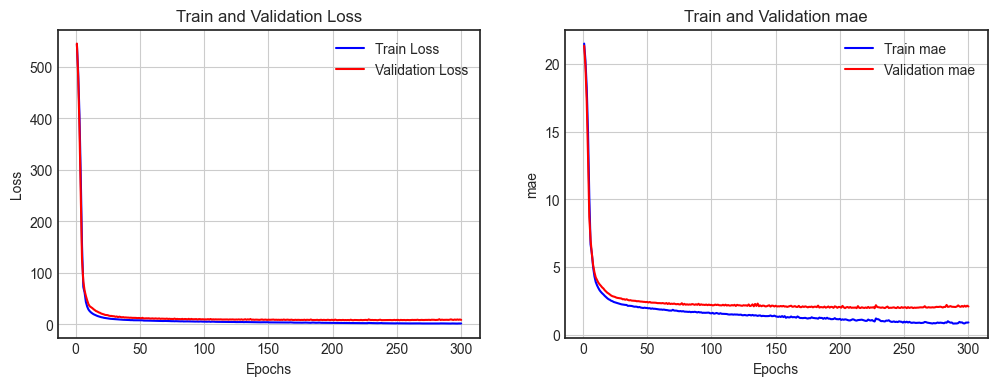

In [15]:
train_loss = model_hist.history["loss"]
val_loss = model_hist.history["val_loss"]
train_mae = model_hist.history["mae"]
val_mae = model_hist.history["val_mae"]

epochs = range(1, len(train_loss) + 1)

fig = plt.figure(figsize=(12, 4))

# 손실(Loss) 그래프
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, train_loss, color="blue", label="Train Loss")
ax1.plot(epochs, val_loss, color="red", label="Validation Loss")
ax1.set_title("Train and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.grid()
ax1.legend()

# mae 그래프
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, train_mae, color="blue", label="Train mae")
ax2.plot(epochs, val_mae, color="red", label="Validation mae")
ax2.set_title("Train and Validation mae")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("mae")
ax2.grid()
ax2.legend()

plt.show()

### K-Fold 교차 검증

- 데이터셋의 크기가 매우 작은 경우에  
  [훈련, 검증, 테스트] 데이터로 나누게 되면 과소적합이 일어날 확률이 높음

- 이를 해결하기 위해 K-Fold 교차 검증 실행
  <br>

  <img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="600">

  <sub>출처: https://scikit-learn.org/stable/modules/cross_validation.html</sub>

### 모델 재구성

In [2]:
tf.random.set_seed(111)

(x_train, y_train), (x_test, y_test) = load_data(test_split=0.2, seed=111)

# 데이터 정규화
scaler = StandardScaler()
x_train, x_test = scaler.fit_transform(x_train), scaler.fit_transform(x_test)

In [3]:
# KFold
k = 3
kfold = KFold(n_splits=k)

# 모델
def build_model():
    input = Input(shape=(13, ), name="input")
    hidden1 = Dense(100, activation="relu", name="hidden1")(input)
    hidden2 = Dense(64, activation="relu", name="hidden2")(hidden1)
    hidden3 = Dense(32, activation="relu", name="hidden3")(hidden2)
    output = Dense(1, name="output")(hidden3)
    model = Model(inputs=[input], outputs=[output])

    model.compile(optimizer=Adam(learning_rate=1e-2),
                  loss="mse",
                  metrics=["mae"])
    
    return model

numpy.ndarray

In [18]:
mae_list = []
train_r2 = []
val_r2 = []
test_r2 = []

for train_idx, val_idx in kfold.split(x_train):
    x_train_fold = x_train[train_idx]
    x_val_fold = x_train[val_idx]
    y_train_fold = y_train[train_idx]
    y_val_fold = y_train[val_idx]

    model = build_model()

    model.fit(x_train_fold, y_train_fold,
              epochs=300,
              validation_data=(x_val_fold, y_val_fold))
    
    y_train_pred = model.predict(x_train_fold)
    train_r2.append(r2_score(y_train_fold, y_train_pred))
    y_val_pred = model.predict(x_val_fold)
    val_r2.append(r2_score(y_val_fold, y_val_pred))

    _, test_mae = model.evaluate(x_test, y_test)

    mae_list.append(test_mae)

Epoch 1/300
9/9 [==============================] - 1s 61ms/step - loss: 349.7894 - mae: 15.9988 - val_loss: 132.9560 - val_mae: 9.1071
Epoch 2/300
9/9 [==============================] - 0s 13ms/step - loss: 55.0518 - mae: 5.4907 - val_loss: 45.9616 - val_mae: 4.9692
Epoch 3/300
9/9 [==============================] - 0s 12ms/step - loss: 35.8854 - mae: 4.5788 - val_loss: 25.7116 - val_mae: 3.5778
Epoch 4/300
9/9 [==============================] - 0s 12ms/step - loss: 17.8327 - mae: 3.0772 - val_loss: 26.3321 - val_mae: 3.8034
Epoch 5/300
9/9 [==============================] - 0s 12ms/step - loss: 16.1387 - mae: 2.9488 - val_loss: 18.0292 - val_mae: 3.1895
Epoch 6/300
9/9 [==============================] - 0s 12ms/step - loss: 13.2146 - mae: 2.6324 - val_loss: 19.6110 - val_mae: 2.8262
Epoch 7/300
9/9 [==============================] - 0s 12ms/step - loss: 11.4118 - mae: 2.3419 - val_loss: 15.5896 - val_mae: 2.8165
Epoch 8/300
9/9 [==============================] - 0s 12ms/step - loss: 1

In [19]:
print(mae_list)
print("Mae Mean: {}".format(np.mean(mae_list)))

[3.071237802505493, 2.9123694896698, 2.9786903858184814]
Mae Mean: 2.9874325593312583


In [20]:
y_test_pred = model.predict(x_test)
test_r2 = r2_score(y_test, y_test_pred)

print(train_r2)
print("Train R2 Mean: {}".format(np.mean(train_r2)))
print(val_r2)
print("Val R2 Mean: {}".format(np.mean(val_r2)))
print("Test R2: {}".format(test_r2))

1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 7ms/step
[0.9904044605777313, 0.9894167151602172, 0.9950308805966083]
Train R2 Mean: 0.9916173521115189
[0.8710123592689654, 0.8833050940739992, 0.841293032162489]
Val R2 Mean: 0.8652034951684845
Test R2: 0.7703962395449275


In [22]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

explainer = shap.DeepExplainer(model, x_train_scale)
shap_values = explainer.shap_values(x_test_scale)
print(shap_values[0].shape)
print(shap_values)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


(102, 13)
[array([[-6.31190238e+00,  5.68381662e-01,  1.41851539e-01, ...,
        -1.10002090e+00, -4.89862398e+00, -3.18199554e+00],
       [ 2.71984641e+00,  7.87074042e-01, -3.72280312e-01, ...,
         1.23341703e-01,  2.79947100e-01, -4.58466109e-01],
       [ 3.90888865e+00,  5.05342836e-01, -1.02781933e+00, ...,
        -1.37164485e+00,  7.25517209e-01,  9.97518243e-03],
       ...,
       [ 2.24941350e-01,  6.32985413e-01,  1.81298559e+00, ...,
         4.32817042e+00,  1.25042219e-01,  1.20551026e+01],
       [ 1.23884797e+00,  8.71492934e-01, -2.07020475e+00, ...,
        -2.73342829e-01,  8.94073871e-03,  1.65599544e+00],
       [-9.69061296e-01,  1.12531564e+00,  1.38759423e+00, ...,
         5.39382034e+00, -1.92621767e-01,  1.27250619e+00]])]


In [72]:
for i in range(x_train_scale.shape[1]):
    feature_imp = np.mean(np.abs(shap_values[0][:, i]))
    print("{}의 중요도: {:.4f}".format(feature_names[i], feature_imp))

CRIM의 중요도: 3.3999
ZN의 중요도: 1.3868
INDUS의 중요도: 0.6165
CHAS의 중요도: 0.2384
NOX의 중요도: 1.6199
RM의 중요도: 2.9901
AGE의 중요도: 1.7075
DIS의 중요도: 2.0888
RAD의 중요도: 2.2910
TAX의 중요도: 1.3153
PTRATIO의 중요도: 0.9541
B의 중요도: 0.4816
LSTAT의 중요도: 2.1679


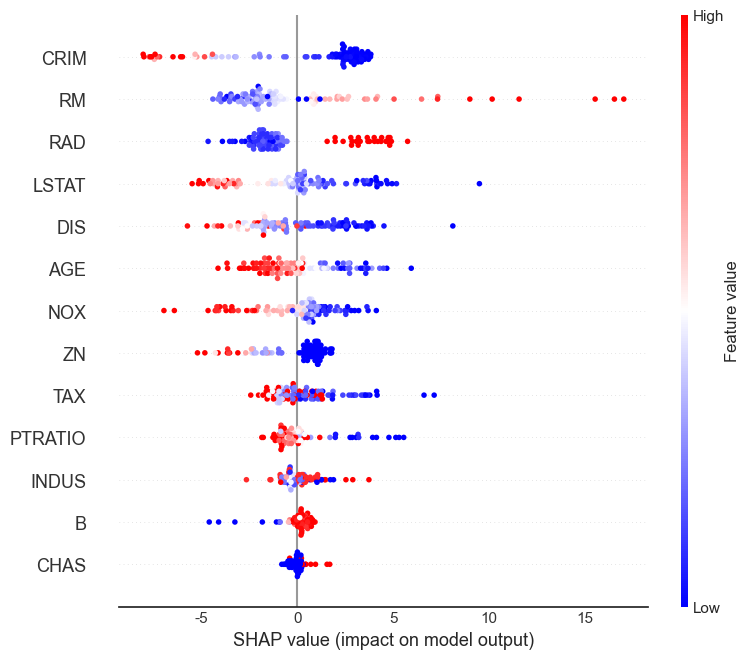

In [95]:
# 전체 피처들에 대해 shapley value가 어떠한 분포를 미치는지 시각화
# Feature Importance와 Feature Effect를 결합함. 여기서 빨간색은 Feature 값이 높다는 것을 의미히며, 파란색은 Feature 값이 낮다는 것을 의미
# 양의 영역에 파란색 점이 찍혀있다면, Feature가 작을수록 긍정적으로 작용한다는 것을 의미
shap.summary_plot(shap_values=shap_values[0],
                  features=x_test_scale,
                  feature_names=feature_names,
                  cmap="bwr");

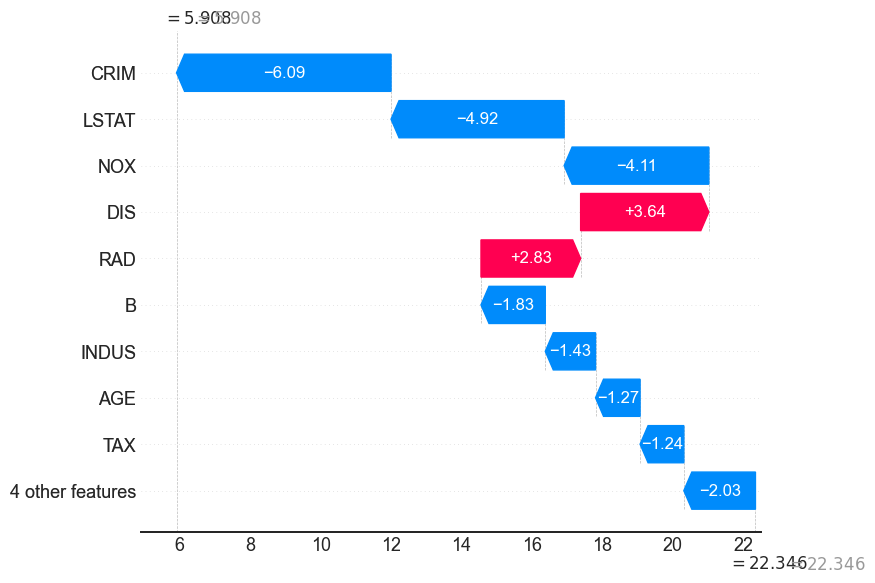

In [119]:
# 특정 데이터가 예측된 근거를 보여줌
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][0], feature_names=feature_names)